In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
!wget https://raw.githubusercontent.com/andrey-source/tehnopark/main/price_of_flats/Test.csv -O Test.csv
!wget https://raw.githubusercontent.com/andrey-source/tehnopark/main/price_of_flats/Train.csv -O Train.csv
!wget https://raw.githubusercontent.com/andrey-source/tehnopark/main/price_of_flats/SampleSubmission.csv -O SampleSubmission.csv
!pip install catboost
import catboost
df = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')

df.head()

--2021-12-04 22:25:45--  https://raw.githubusercontent.com/andrey-source/tehnopark/main/price_of_flats/Test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6609106 (6.3M) [text/plain]
Saving to: ‘Test.csv’

Test.csv            100%[===================>]   6.30M  --.-KB/s    in 0.08s   

2021-12-04 22:25:45 (74.6 MB/s) - ‘Test.csv’ saved [6609106/6609106]

--2021-12-04 22:25:45--  https://raw.githubusercontent.com/andrey-source/tehnopark/main/price_of_flats/Train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7323254 (7.0M

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0,2011-1,30,0.0,10,48,2,0,30.0,NaN,4,0,1,0,0,0,0,0,0,0,0,0,0,0,4252000
1,1,2011-1,376,1.0,2,53,2,0,30.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4463000
2,2,2011-1,549,NaN,8,61,3,1,30.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4518000
3,3,2011-1,321,1.0,10,47,1,1,30.0,0.0,6,0,1,0,0,0,0,0,0,0,0,0,0,0,6785000
4,4,2011-1,636,NaN,3,58,3,0,25.0,NaN,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1677000


In [3]:
df['year'] = pd.DatetimeIndex(df.date).year - 2011
df['month'] = pd.DatetimeIndex(df.date).month
df['mohth_from_begin'] = df.year * 12 + pd.DatetimeIndex(df.date).month
df_test['year'] = pd.DatetimeIndex(df_test.date).year - 2011
df_test['month'] = pd.DatetimeIndex(df_test.date).month
df_test['mohth_from_begin'] = df_test.year * 12 + pd.DatetimeIndex(df_test.date).month

del df['date']
del df_test['date']
df = df.iloc[df.price.values != 1000000, :]  # удаляю вброс


df['price_m2'] = df.price / df.area
df.reset_index(inplace=True)
del df['index']
del df['id']
df.shape

(95993, 27)

In [4]:
# df[df.year.values == 1].groupby('month').mean().price.plot()  # цикличности вроде нет
# df[df.year.values == 0].groupby('month').mean().price.plot()  
del df['month']

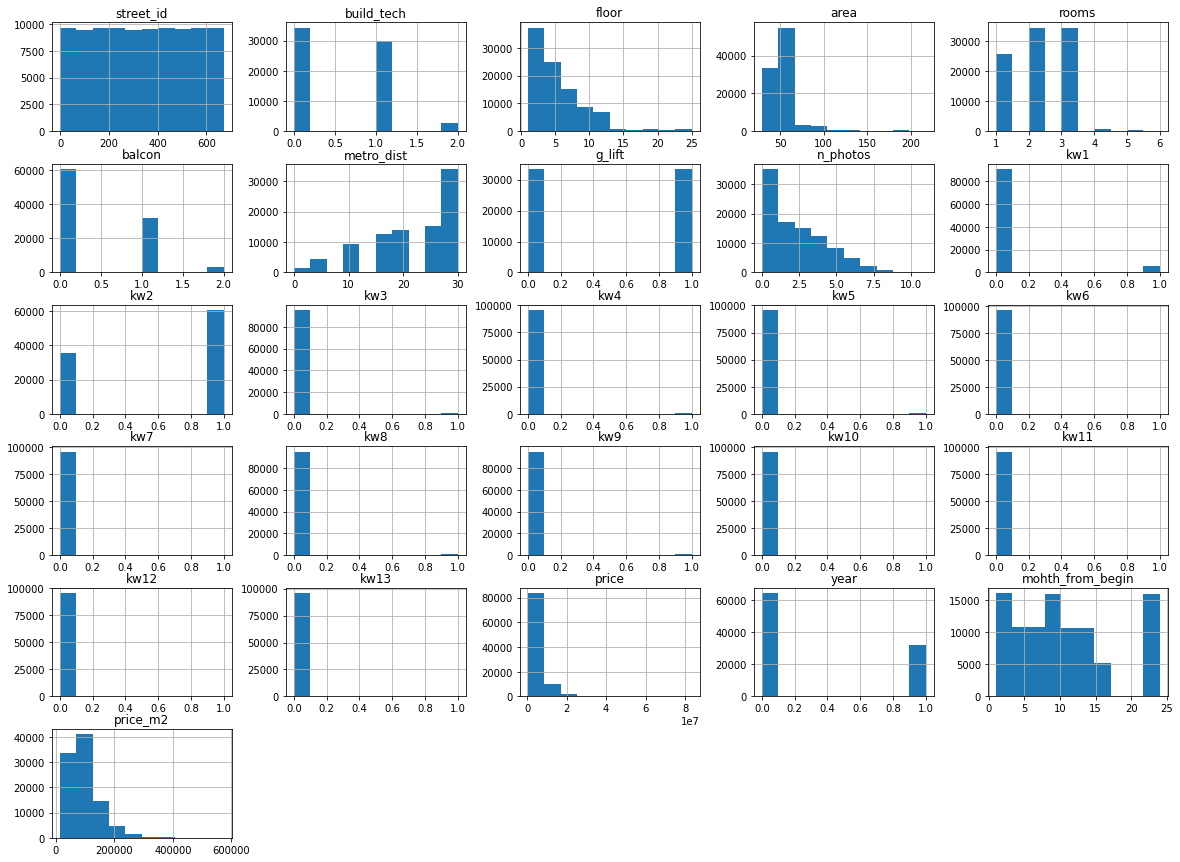

In [5]:
df.hist(figsize=(20, 15))
None

Тренировочная выборка mohth_from_begin<= 15, валидационная >15

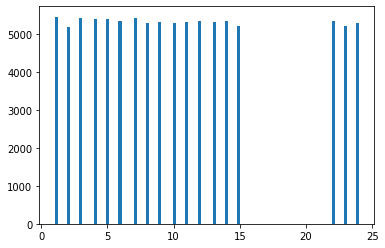

In [6]:
plt.hist(df.mohth_from_begin.values, bins=100)
None

Проверяю связь признака с ценой

In [7]:
# check = df[{'price', 'build_tech'}].groupby('build_tech').mean()  # можно рассматривать как числовой признак
# check = df[{'price', 'street_id'}].groupby('street_id').mean()  # категориальный
# check = df[{'price', 'floor'}].groupby('floor').mean()  # числовой 
# check = df[{'price', 'balcon'}].groupby('balcon').mean()  # можно рассматривать как числовой признак
# check = df[{'price', 'metro_dist'}].groupby('metro_dist').mean()  # числовой
# check = df[{'price', 'g_lift'}].groupby(['g_lift']).mean()  # бесполезный на первый взгляд
# check = df[{'price', 'street_id', 'g_lift'}].groupby(['street_id', 'g_lift']).mean()  # а так очень даже ничего - числовой
# check = df[{'price', 'n_photos'}].groupby('n_photos').mean()  # числовой
# check = df[{'price', 'kw1'}].groupby('kw1').mean()  # числовой
# check = df[{'price', 'kw2'}].groupby('kw2').mean()  # числовой
# check = df[{'price', 'kw3'}].groupby('kw3').mean()  # числовой
# check = df[{'price', 'kw4'}].groupby('kw4').mean()  # числовой
# check = df[{'price', 'kw5'}].groupby('kw5').mean()  # числовой
# check = df[{'price', 'kw6'}].groupby('kw6').mean()  # числовой
# check = df[{'price', 'kw7'}].groupby('kw7').mean()  # числовой
# check = df[{'price', 'kw8'}].groupby('kw8').mean()  # числовой  # не вижу информативности, при том, что сильно несбалансированы - выкидываю
# check = df[{'price', 'kw9'}].groupby('kw9').mean()  # числовой  #не вижу информативност, что сильно несбалансированы - выкидываю
# check = df[{'price', 'kw10'}].groupby('kw10').mean()  # числовой
# check = df[{'price', 'kw11'}].groupby('kw11').mean()  # числовой
# check = df[{'price', 'kw12'}].groupby('kw12').mean()  # числовой
check = df[{'price', 'kw13'}].groupby('kw13').mean()  # числовой
check

,price
kw13,
0,5.350703e+06
1,1.465262e+07


In [8]:
del (df['kw8'])
del (df['kw9'])
del (df_test['kw8'])
del (df_test['kw9'])
del (df_test['g_lift'])
del (df['g_lift'])

Пропуски: build_tech, metro_dist, g_lift Проверяю с чем это связано. Так же проставляю веса наблюдениями. По принципу, есть пропуск - вес меньше. В конце все же выяснилось, что g_lift мусорный признак. Его удаляю.

Считаю веса наблюдений. Редкие более ценны чем частые

In [9]:
df['weights_unique'] = 0
counts = df.price.value_counts().values
values = df.price.value_counts().index.values
for i in range(values.shape[0]):
    df.weights_unique[df.price.values == values[i]] = 1 / np.cbrt(counts[i])  # веса наблюдений

In [10]:
df['weights_miss'] = 1
df.fillna(value=-9999, inplace=True)
df.weights_miss[df.metro_dist.values == -9999] = df.weights_miss[df.metro_dist.values == -9999] * 0.7 # предсказывается средне
df.weights_miss[df.build_tech.values == -9999] = df.weights_miss[df.build_tech.values == -9999] * 0.8  # предсказывается хорошо
df['weights'] = df.weights_unique * df.weights_miss
df_test.fillna(value=-9999, inplace=True)


In [11]:
# check = df.groupby('build_tech').mean()  # скорее всего просто разбросаны. Имеет смысл заполнять моделью
# check = df.groupby(['g_lift']).mean() # скорее всего просто разбросаны. Имеет смысл заполнять моделью
# check = df[{'street_id', 'g_lift', 'price'}].groupby(['street_id', 'g_lift']).mean() 
# check = df.groupby(['g_lift']).mean()
check = df[{'metro_dist', 'price'}].groupby(['metro_dist']).mean() # скорее всего просто разбросаны. Имеет смысл заполнять моделью 
check.head(20)

,price
metro_dist,
-9999.0,5.334405e+06
0.0,7.001557e+06
5.0,6.607968e+06
10.0,6.322894e+06
15.0,5.743570e+06
20.0,5.465226e+06
25.0,5.343031e+06
30.0,4.666689e+06


Заполняю build_tech

In [12]:
from catboost import CatBoostClassifier 
from catboost import Pool

df_train = df[(df.mohth_from_begin.values < 20) * (df.build_tech.values != -9999)]
df_valid = df[(df.mohth_from_begin.values > 20) * (df.build_tech.values != -9999)]

features = ['street_id', 'floor', 'area', 'rooms', 'balcon', 'n_photos',
            'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw10', 'kw11', 'kw12', 'kw13']
cat_features = ['street_id']


train_pool = Pool(data=df_train[features], label=df_train.build_tech.values, cat_features=cat_features, weight = df_train.weights.values)
valid_pool = Pool(df_valid[features], label=df_valid.build_tech.values, cat_features=cat_features)
build_model = CatBoostClassifier(random_state=42
                                 )
build_model.fit(train_pool, eval_set=valid_pool)
pred_train = build_model.predict(df_train[features])
pred_valid = build_model.predict(df_valid[features])

Learning rate set to 0.117035
0:	learn: 0.9315210	test: 0.9318246	best: 0.9318246 (0)	total: 138ms	remaining: 2m 17s
1:	learn: 0.8085085	test: 0.8085973	best: 0.8085973 (1)	total: 242ms	remaining: 2m
2:	learn: 0.7151850	test: 0.7148881	best: 0.7148881 (2)	total: 333ms	remaining: 1m 50s
3:	learn: 0.6416098	test: 0.6412650	best: 0.6412650 (3)	total: 427ms	remaining: 1m 46s
4:	learn: 0.5834036	test: 0.5832720	best: 0.5832720 (4)	total: 511ms	remaining: 1m 41s
5:	learn: 0.5330583	test: 0.5327010	best: 0.5327010 (5)	total: 602ms	remaining: 1m 39s
6:	learn: 0.4899683	test: 0.4901460	best: 0.4901460 (6)	total: 681ms	remaining: 1m 36s
7:	learn: 0.4544279	test: 0.4552052	best: 0.4552052 (7)	total: 764ms	remaining: 1m 34s
8:	learn: 0.4238545	test: 0.4249500	best: 0.4249500 (8)	total: 843ms	remaining: 1m 32s
9:	learn: 0.3993455	test: 0.4004194	best: 0.4004194 (9)	total: 922ms	remaining: 1m 31s
10:	learn: 0.3747275	test: 0.3764422	best: 0.3764422 (10)	total: 998ms	remaining: 1m 29s
11:	learn: 0.35

In [13]:
from sklearn.metrics import classification_report
print("train: \n", classification_report(pred_train, df_train.build_tech.values))
print("valid: \n", classification_report(pred_valid, df_valid.build_tech.values))

train: 
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.95     29840
         1.0       0.92      0.96      0.94     23934
         2.0       0.97      0.98      0.98      2373

    accuracy                           0.95     56147
   macro avg       0.96      0.96      0.96     56147
weighted avg       0.95      0.95      0.95     56147

valid: 
               precision    recall  f1-score   support

         0.0       0.96      0.93      0.95      5800
         1.0       0.92      0.95      0.93      4805
         2.0       0.95      0.97      0.96       460

    accuracy                           0.94     11065
   macro avg       0.94      0.95      0.95     11065
weighted avg       0.94      0.94      0.94     11065



In [14]:
df.build_tech[df.build_tech.values == -9999] = build_model.predict(df[df.build_tech.values == -9999][features].values).reshape(-1)
df_test.build_tech[df_test.build_tech == -9999] = build_model.predict(df_test[df_test.build_tech.values == -9999][features].values).reshape(-1)

In [15]:
from catboost import CatBoostRegressor

df_train = df[(df.mohth_from_begin.values < 20) * (df.metro_dist.values != -9999)]
df_valid = df[(df.mohth_from_begin.values > 20) * (df.metro_dist.values != -9999)]

features = ['build_tech', 'street_id', 'floor', 'area', 'rooms', 'balcon', 'n_photos',
            'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw10', 'kw11', 'kw12', 'kw13']
cat_features = ['street_id']

train_pool = Pool(data=df_train[features], label=df_train.metro_dist, cat_features=cat_features, weight = df_train.weights.values)
valid_pool = Pool(data=df_valid[features], label=df_valid.metro_dist, cat_features=cat_features)
metro_model = CatBoostRegressor(loss_function = 'MAE', eval_metric='MAE', 
                random_state=42, n_estimators=3000,
)
metro_model.fit(train_pool, eval_set=valid_pool)
pred_train = metro_model.predict(df_train[features])
pred_valid = metro_model.predict(df_valid[features])

0:	learn: 7.0354664	test: 6.9195715	best: 6.9195715 (0)	total: 43.7ms	remaining: 2m 11s
1:	learn: 6.9985814	test: 6.8818687	best: 6.8818687 (1)	total: 83.4ms	remaining: 2m 4s
2:	learn: 6.9610636	test: 6.8431585	best: 6.8431585 (2)	total: 120ms	remaining: 1m 59s
3:	learn: 6.9245360	test: 6.8041503	best: 6.8041503 (3)	total: 155ms	remaining: 1m 55s
4:	learn: 6.8914435	test: 6.7687481	best: 6.7687481 (4)	total: 187ms	remaining: 1m 51s
5:	learn: 6.8562629	test: 6.7311355	best: 6.7311355 (5)	total: 219ms	remaining: 1m 49s
6:	learn: 6.8236711	test: 6.6975621	best: 6.6975621 (6)	total: 258ms	remaining: 1m 50s
7:	learn: 6.7928986	test: 6.6646693	best: 6.6646693 (7)	total: 294ms	remaining: 1m 50s
8:	learn: 6.7639939	test: 6.6333788	best: 6.6333788 (8)	total: 326ms	remaining: 1m 48s
9:	learn: 6.7364967	test: 6.6042324	best: 6.6042324 (9)	total: 357ms	remaining: 1m 46s
10:	learn: 6.7061250	test: 6.5736505	best: 6.5736505 (10)	total: 386ms	remaining: 1m 44s
11:	learn: 6.6778112	test: 6.5442460	bes

In [16]:
from sklearn.metrics import mean_absolute_error
print("train: \n", mean_absolute_error(pred_train, df_train.metro_dist.values))
print("valid: \n", mean_absolute_error(pred_valid, df_valid.metro_dist.values))

train: 
 5.279782415090771
valid: 
 5.451078880691465


In [17]:
df.metro_dist[df.metro_dist.values == -9999] = metro_model.predict(df[df.metro_dist.values == -9999][features])
df_test.metro_dist[df_test.metro_dist == -9999] = metro_model.predict(df_test[df_test.metro_dist.values == -9999][features])

In [18]:
# округляю
df.metro_dist = round(df.metro_dist / 5) * 5  
df_test.metro_dist = round(df_test.metro_dist / 5) * 5

Анализирую стомость квартир в каждом месяце. Делаю преобразование Бокса-Кокса. Получаю распределения очень похожие на нормальные. Удобно отслеживать пороговые значения -3, 3 стандартных отклонений, на предмет выбросов.

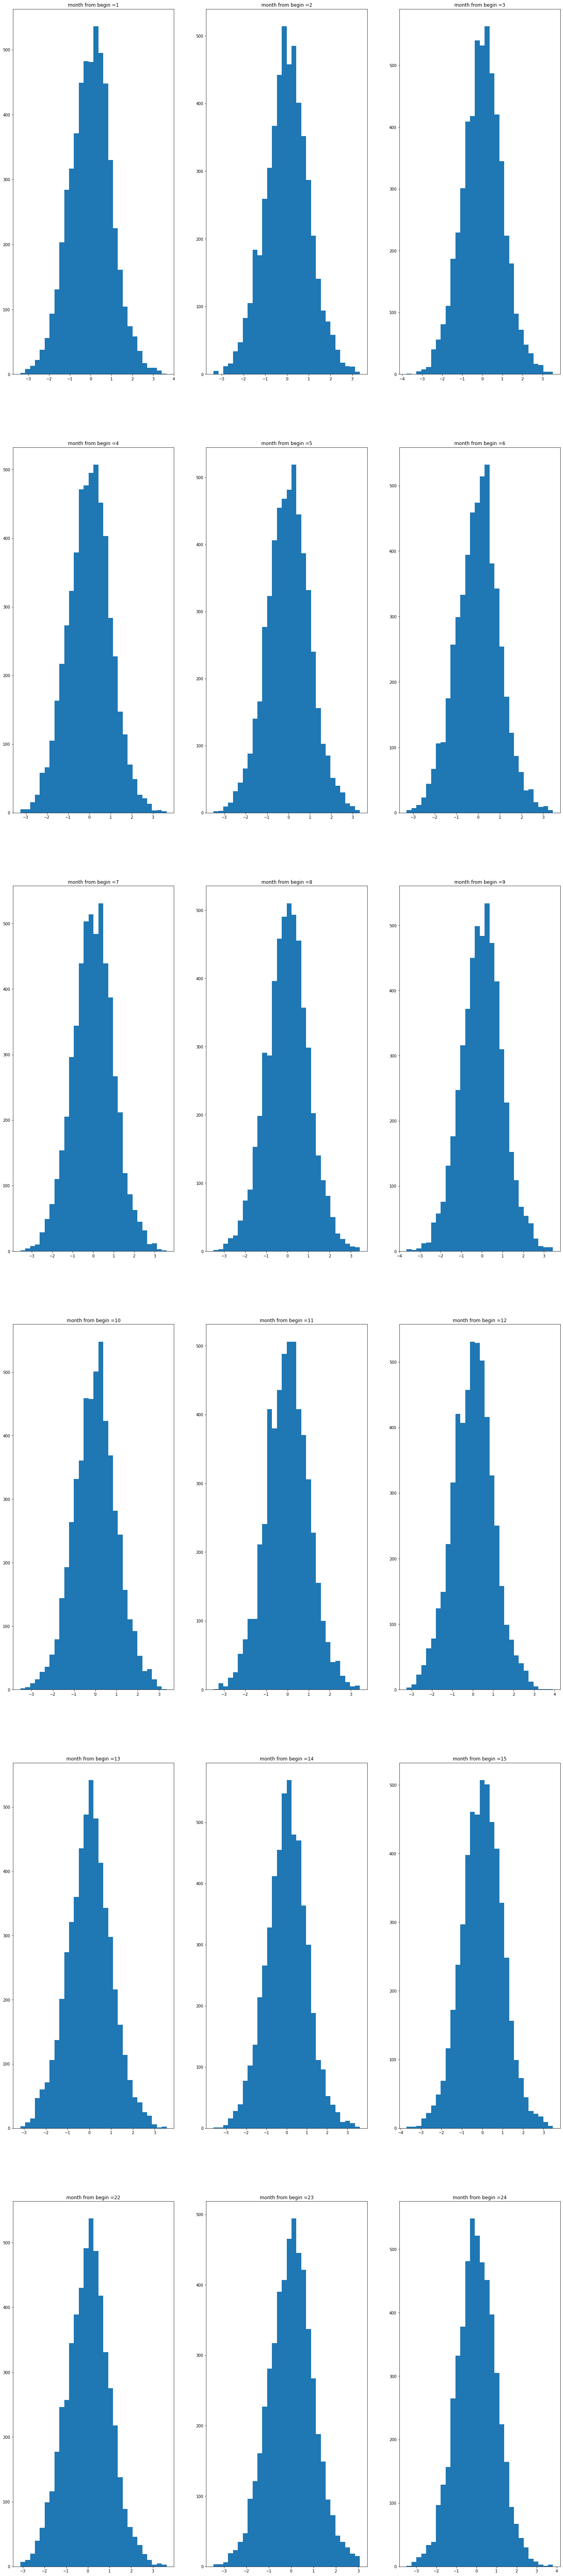

In [19]:
from sklearn.preprocessing import PowerTransformer
spisok = []
y = df.mohth_from_begin.values
df['normal_price_month'] = 0.0
for i in np.unique(y):
    PW = PowerTransformer(method='box-cox')
    PW.fit(df.price[y == i].values.reshape(-1, 1))
    df.normal_price_month[y == i] = PW.transform(df.price[y == i].values.reshape(-1, 1)).reshape(-1)
    spisok.append(PW)
    
fig, ax = plt.subplots(6, 3, figsize=(25,120))
n, k, i = 0, 0, 0
for i, month in enumerate(np.unique(y)):
    ax[i // 3, i % 3].hist(df.normal_price_month[y == month].values, bins = 30)
    ax[i // 3, i % 3].set_title('month from begin =' + str(month))

Стоймость квартир в зависимости от улицы

In [20]:
street_spisok = []
y = df.street_id.values
df['normal_price_street'] = 0.0
for i in np.unique(y):
    PW = PowerTransformer(method='box-cox')
    PW.fit(df.price[y == i].values.reshape(-1, 1))
    df.normal_price_street[y == i] = PW.transform(df.price[y == i].values.reshape(-1, 1)).reshape(-1)
    street_spisok.append(PW)

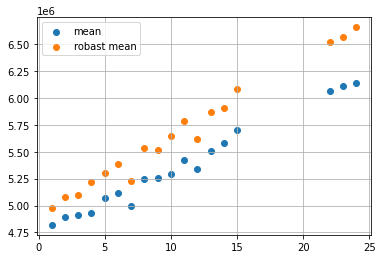

In [21]:
mean_price = df[['price', 'mohth_from_begin']].groupby(['mohth_from_begin']).mean()  # просто средня цена


df['weight_price'] = df.price * df.weights  # вклад в стоймость, нет пропусков и уникальное значение стоймости - большой вклад
mask1 = (df['normal_price_month'].values < 2) * (df['normal_price_month'].values > -2) # выбираю только квартиры с ценами в пределах -2 2 стандартных отклонений по месяцам
mask2 = (df['normal_price_street'].values < 3) * (df['normal_price_street'].values > -3) # выбираю только квартиры с ценами в пределах -3 3 стандартных отклонений по улицам 
mask = mask1 * mask2
robast_mean_price = df[['weight_price', 'mohth_from_begin']][mask].groupby(['mohth_from_begin']).sum() / df[['weights', 'mohth_from_begin']][mask].groupby(['mohth_from_begin']).sum().values
plt.scatter(mean_price.index, mean_price.values, label = "mean")
plt.scatter(robast_mean_price.index, robast_mean_price.values, label = "robast mean")
plt.grid()
plt.legend()
plt.show()

В старых данных был экспонециальный рост!!!

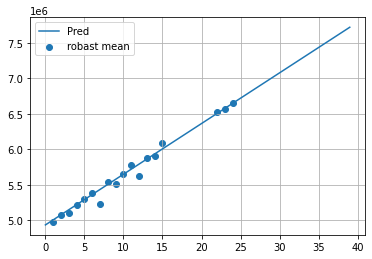

In [22]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

train = robast_mean_price[:15]
linear_model = SVR(kernel = 'poly', degree= 1, C = 1e5).fit(X = train.index.values.reshape(-1, 1), y = train.values)
pred = linear_model.predict(X = np.arange(0, 40).reshape(-1, 1))

plt.plot(np.arange(0, 40).reshape(-1, 1), pred, label = "Pred")
plt.scatter(robast_mean_price.index, robast_mean_price.values, label = "robast mean")
plt.grid()
plt.legend()
plt.show()

Вычисляю коэффицент стоймости от месяца по модели

In [23]:
time_0 = linear_model.predict([[0]])
df['pred_mean'] = linear_model.predict(df.mohth_from_begin.values.reshape(-1, 1))  # прогноз средней цены
df['model_time_coef'] = df.pred_mean / time_0  # коэффициент стоймости от времени
df['model_price_without_time'] = df.price / df.model_time_coef  # цена с поправкой на время
df_test['model_pred_mean'] = linear_model.predict(df_test.mohth_from_begin.values.reshape(-1, 1))  # прогноз средней цены для теста
df_test['model_time_coef'] = df_test.model_pred_mean / time_0

Вычисляю коэффицент стоймости от месяца, как отношение рабастных оценок стоймости

In [24]:
df['time_coef'] = 0
for i in df.mohth_from_begin.unique():
    df.time_coef[df.mohth_from_begin.values == i] = robast_mean_price.loc[i].values / robast_mean_price.loc[1].values
df['price_without_time'] = df.price / df.time_coef

Стоймость квадратного метра в зависимости от даты и улицы

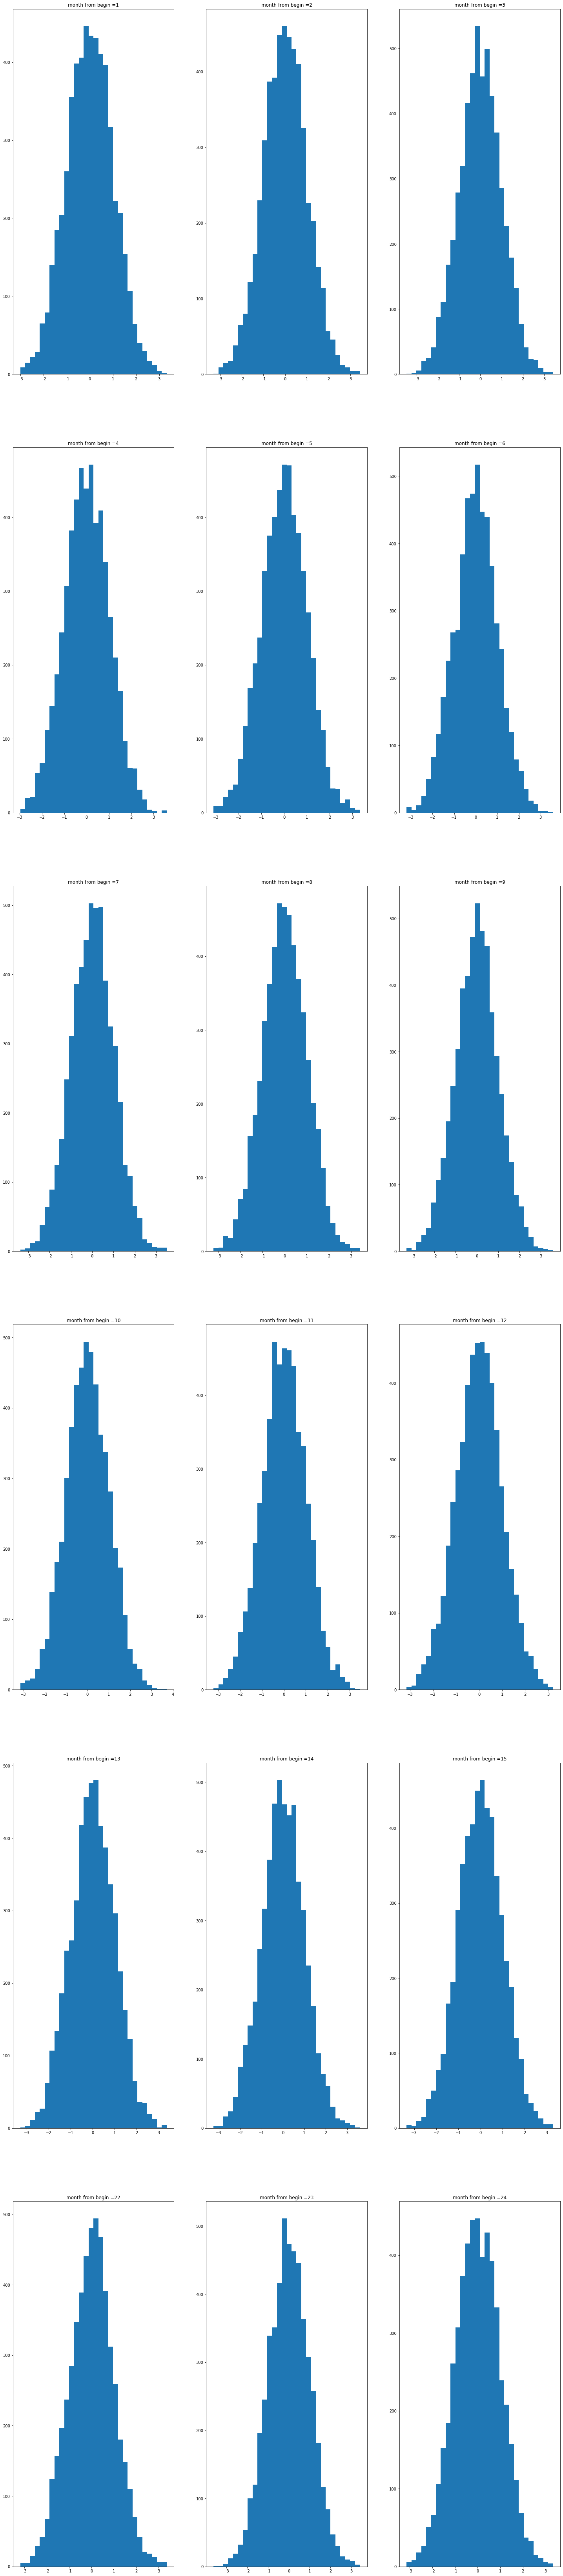

In [25]:
spisok = []
y = df.mohth_from_begin.values
df['normal_price_month_m2'] = 0.0
for i in np.unique(y):
    PW = PowerTransformer(method='box-cox')
    PW.fit(df.price_m2[y == i].values.reshape(-1, 1))
    df.normal_price_month_m2[y == i] = PW.transform(df.price_m2[y == i].values.reshape(-1, 1)).reshape(-1)
    spisok.append(PW)
    
fig, ax = plt.subplots(6, 3, figsize=(25,120))
n, k, i = 0, 0, 0
for i, month in enumerate(np.unique(y)):
    ax[i // 3, i % 3].hist(df.normal_price_month_m2[y == month].values, bins = 30)
    ax[i // 3, i % 3].set_title('month from begin =' + str(month))

In [26]:
street_spisok = []
y = df.street_id.values
df['normal_price_street_m2'] = 0.0
for i in np.unique(y):
    PW = PowerTransformer(method='box-cox')
    PW.fit(df.price_m2[y == i].values.reshape(-1, 1))
    df.normal_price_street_m2[y == i] = PW.transform(df.price_m2[y == i].values.reshape(-1, 1)).reshape(-1)
    street_spisok.append(PW)


In [27]:
df[df.normal_price_street_m2.values > 3]

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,n_photos,kw1,kw2,kw3,kw4,kw5,kw6,kw7,kw10,kw11,kw12,kw13,price,year,mohth_from_begin,price_m2,weights_unique,weights_miss,weights,normal_price_month,normal_price_street,weight_price,pred_mean,model_time_coef,model_price_without_time,time_coef,price_without_time,normal_price_month_m2,normal_price_street_m2
57000,533,1.0,3,95,3,1,25.0,0,0,1,0,0,0,0,0,0,0,0,0,15149000,0,8,159463.157895,0.793701,1.0,0.793701,1.890151,3.006576,1.202377e+07,5.506220e+06,1.115734,1.357761e+07,1.111600,1.362811e+07,1.268198,3.865285
58600,641,1.0,10,51,1,0,20.0,3,1,0,0,0,0,0,0,0,0,0,0,13527000,0,8,265235.294118,0.793701,0.8,0.634960,1.737961,1.417092,8.589110e+06,5.506220e+06,1.115734,1.212386e+07,1.111600,1.216895e+07,2.262890,3.088052
69852,636,1.0,10,60,3,1,5.0,2,0,1,0,0,0,0,0,0,0,0,0,2952000,1,22,49200.000000,0.388911,1.0,0.388911,-0.761267,2.850583,1.148066e+06,6.505741e+06,1.318268,2.239301e+06,1.309809,2.253763e+06,-1.341785,3.069953
70113,39,0.0,7,34,1,0,20.0,5,0,1,0,0,0,0,0,0,0,0,0,3275000,1,22,96323.529412,0.414913,0.8,0.331931,-0.589191,0.492576,1.087073e+06,6.505741e+06,1.318268,2.484320e+06,1.309809,2.500364e+06,-0.003700,3.244039
71665,390,1.0,5,62,2,0,5.0,1,0,0,0,0,0,0,0,0,0,0,0,16632000,1,22,268258.064516,1.000000,1.0,1.000000,1.817106,1.837923,1.663200e+07,6.505741e+06,1.318268,1.261655e+07,1.309809,1.269803e+07,1.958382,3.048491
73198,653,1.0,9,34,1,1,15.0,4,1,0,0,0,0,0,0,0,0,0,0,4727000,1,22,139029.411765,0.449644,0.8,0.359715,0.000344,0.209267,1.700375e+06,6.505741e+06,1.318268,3.585765e+06,1.309809,3.608922e+06,0.709941,3.122310
73866,455,1.0,3,52,2,0,10.0,0,1,1,0,0,0,0,0,0,0,0,0,3027000,1,22,58211.538462,0.368403,1.0,0.368403,-0.719472,2.295037,1.115156e+06,6.505741e+06,1.318268,2.296194e+06,1.309809,2.311023e+06,-1.002906,3.244114
74120,256,1.0,3,99,3,1,25.0,5,0,0,0,0,0,0,0,0,0,0,0,13991000,1,22,141323.232323,1.000000,1.0,1.000000,1.584973,2.835987,1.399100e+07,6.505741e+06,1.318268,1.061317e+07,1.309809,1.068171e+07,0.741484,3.026827
75057,409,1.0,11,51,2,1,25.0,1,1,1,0,0,0,0,0,0,0,0,0,7958000,1,23,156039.215686,0.522758,1.0,0.522758,0.776526,2.082877,4.160108e+06,6.577135e+06,1.332735,5.971179e+06,1.319148,6.032683e+06,0.915735,3.118116
75621,295,1.0,10,52,2,0,5.0,7,0,1,0,0,0,0,0,0,0,0,0,11248000,1,23,216307.692308,0.693361,1.0,0.693361,1.275718,2.543270,7.798928e+06,6.577135e+06,1.332735,8.439787e+06,1.319148,8.526717e+06,1.558943,3.059323


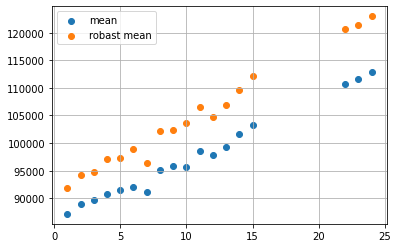

In [28]:
mean_price_m2 = df[['price_m2', 'mohth_from_begin']].groupby(['mohth_from_begin']).mean()  # просто средня цена


df['weight_price_m2'] = df.price_m2 * df.weights  # вклад в стоймость, нет пропусков и уникальное значение стоймости - большой вклад
mask1 = (df['normal_price_month'].values < 2) * (df['normal_price_month'].values > -2) # выбираю только квартиры с ценами в пределах -1 1 стандартных отклонений по месяцам
mask2 = (df['normal_price_street'].values < 3) * (df['normal_price_street'].values > -3) # выбираю только квартиры с ценами в пределах -2 2 стандартных отклонений по улицам (здесь 2 тк их выборка для каждого меньше)
mask = mask1 * mask2
robast_mean_price_m2 = df[['weight_price_m2', 'mohth_from_begin']][mask].groupby(['mohth_from_begin']).sum() / df[['weights', 'mohth_from_begin']][mask].groupby(['mohth_from_begin']).sum().values
plt.scatter(mean_price_m2.index, mean_price_m2.values, label = "mean")
plt.scatter(robast_mean_price_m2.index, robast_mean_price_m2.values, label = "robast mean")
plt.grid()
plt.legend()
plt.show()

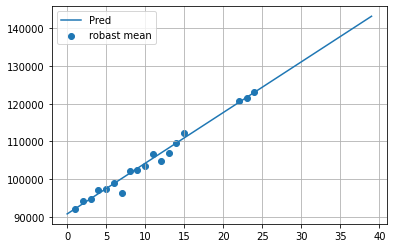

In [29]:
train = robast_mean_price_m2[:15]
linear_model = SVR(kernel = 'poly', degree = 1,  C = 10000).fit(X = train.index.values.reshape(-1, 1), y = train.values)

pred = linear_model.predict(X = np.arange(0, 40).reshape(-1, 1))

plt.plot(np.arange(0, 40).reshape(-1, 1), pred, label = "Pred")
plt.scatter(robast_mean_price_m2.index, robast_mean_price_m2.values, label = "robast mean")
plt.grid()
plt.legend()
plt.show()

In [30]:
time_0 = linear_model.predict([[0]])
df['model_pred_mean_m2'] = linear_model.predict(df.mohth_from_begin.values.reshape(-1, 1))
df_test['model_pred_mean_m2'] = linear_model.predict(df_test.mohth_from_begin.values.reshape(-1, 1))
df['model_coef_price_m2'] = df['price_m2'] / df['model_pred_mean_m2'] # во сколько квартира лучше средней
df['model_time_coef_m2'] = df.model_pred_mean_m2 / time_0
df['model_price_m2_without_time'] = df.price_m2 / df.model_time_coef_m2


In [31]:
df['time_coef_m2'] = 0
for i in df.mohth_from_begin.unique():
    df.time_coef_m2[df.mohth_from_begin.values == i] = robast_mean_price_m2.loc[i].values / robast_mean_price_m2.loc[1].values
df['price_m2_without_time'] = df.price_m2 / df.time_coef_m2

Выполняю кластеризацию. По площади и стоймости квадратного метра с поправкой на время

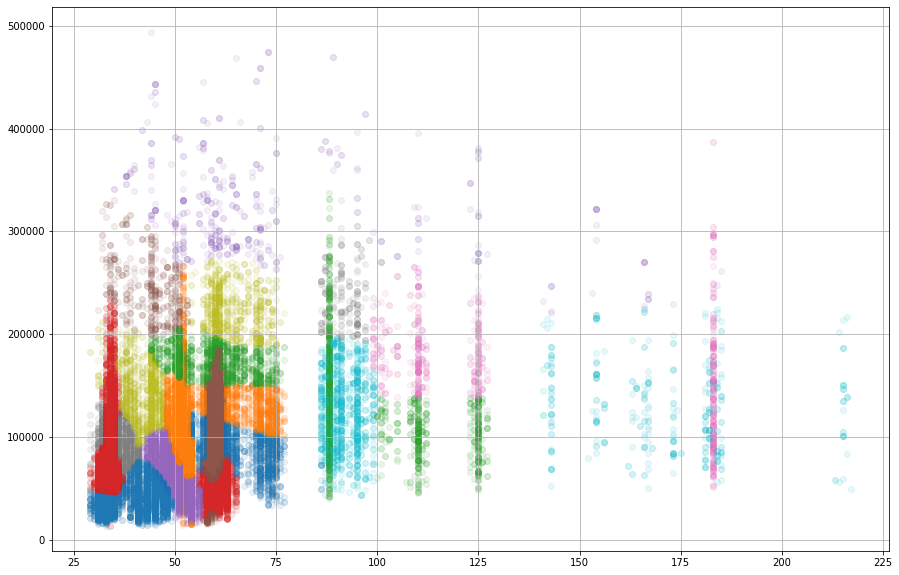

In [85]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())  # список цветов

df_train = df[(df.mohth_from_begin.values < 20) * (df.build_tech.values != -9999)]
train = df_train.sample(frac = 0.6, replace = True, random_state = 42, weights = df_train.weights)

claster = ['area', 'model_price_m2_without_time']
classtering = Pipeline([
    ('SS', StandardScaler()),
    ('GaussianMixture', GaussianMixture(n_components = 25, random_state = 42, n_init = 10)) 
])

labels = classtering.fit_predict(train[claster])


plt.figure(figsize=(15, 10))
plt.grid()
for i in np.unique(labels):
    plt.scatter(train.area[i == labels].values, train.model_price_m2_without_time[i==labels].values, cmap=colors_list[i], alpha=0.1)
plt.show()

In [86]:
df_train['labels'] = classtering.predict(df_train[claster])

Предсказываю метку кластера по известным признакам

In [87]:
train, valid = train_test_split(df_train, train_size=0.7)
features = ['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon', 'metro_dist', 'n_photos', 
           'kw1', 'kw2', 'kw3', 'kw4', 'kw5', 'kw6', 'kw7', 'kw10', 'kw11', 'kw12', 'kw13']
cat_features = ['street_id']

target = ['labels']

train_pool = Pool(train[features], label=train[target], weight = train.weights.values)
valid_pool  =Pool(valid[features], label=valid[target])

model = CatBoostClassifier(n_estimators=2000, random_state=42,
                           auto_class_weights='SqrtBalanced'
                    
)
model.fit(train_pool, eval_set=valid_pool)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.089807
0:	learn: 2.7004768	test: 2.6590963	best: 2.6590963 (0)	total: 280ms	remaining: 9m 18s
1:	learn: 2.4556162	test: 2.3947380	best: 2.3947380 (1)	total: 522ms	remaining: 8m 41s
2:	learn: 2.2887493	test: 2.2228770	best: 2.2228770 (2)	total: 770ms	remaining: 8m 32s
3:	learn: 2.1527584	test: 2.0750343	best: 2.0750343 (3)	total: 1.02s	remaining: 8m 28s
4:	learn: 2.0351769	test: 1.9549957	best: 1.9549957 (4)	total: 1.27s	remaining: 8m 25s
5:	learn: 1.9376926	test: 1.8593794	best: 1.8593794 (5)	total: 1.51s	remaining: 8m 23s
6:	learn: 1.8645850	test: 1.7841948	best: 1.7841948 (6)	total: 1.76s	remaining: 8m 21s
7:	learn: 1.7816333	test: 1.7102145	best: 1.7102145 (7)	total: 2.01s	remaining: 8m 21s
8:	learn: 1.7150679	test: 1.6445972	best: 1.6445972 (8)	total: 2.25s	remaining: 8m 18s
9:	learn: 1.6678700	test: 1.5932305	best: 1.5932305 (9)	total: 2.5s	remaining: 8m 17s
10:	learn: 1.6159162	test: 1.5432186	best: 1.5432186 (10)	total: 2.74s	remaining: 8m 15s
11:	learn: 1

In [88]:
pred_train = model.predict(train_pool)
pred_valid = model.predict(valid_pool)

In [89]:
train['pred_labels'] = pred_train
valid['pred_labels'] = pred_valid

In [90]:
from sklearn.metrics import classification_report
print("train: \n", classification_report(pred_train, train.labels.values))
print("valid: \n", classification_report(pred_valid, valid.labels.values))

train: 
               precision    recall  f1-score   support

           0       0.76      0.69      0.73      3136
           1       1.00      1.00      1.00      5043
           2       1.00      1.00      1.00       683
           3       0.71      0.78      0.74      5991
           4       1.00      0.96      0.98       200
           5       0.86      0.82      0.84      9882
           6       1.00      1.00      1.00       178
           7       0.86      0.76      0.81      1491
           8       0.93      0.85      0.89       552
           9       1.00      1.00      1.00       736
          10       0.83      0.83      0.83      1718
          11       0.84      0.84      0.84       955
          12       0.99      0.99      0.99       367
          13       0.78      0.73      0.75      3633
          14       0.75      0.81      0.78      5814
          15       0.98      0.88      0.92       376
          16       0.99      0.99      0.99       257
          17      

Так выглядят истинные метки

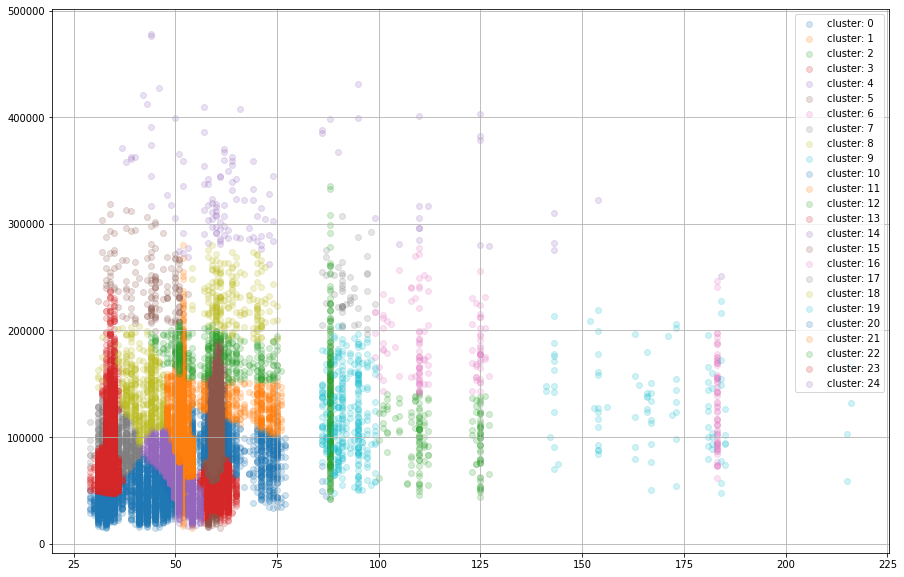

In [91]:
plt.figure(figsize=(15, 10))
plt.grid()
for i in np.unique(train.pred_labels.unique()):
    plt.scatter(valid.area[i == valid.labels].values, valid.price_m2_without_time[i==valid.labels].values,
                cmap=colors_list[i], alpha=0.2, label ='cluster: ' + str(i))
plt.legend()
plt.show()

А так прогнозные

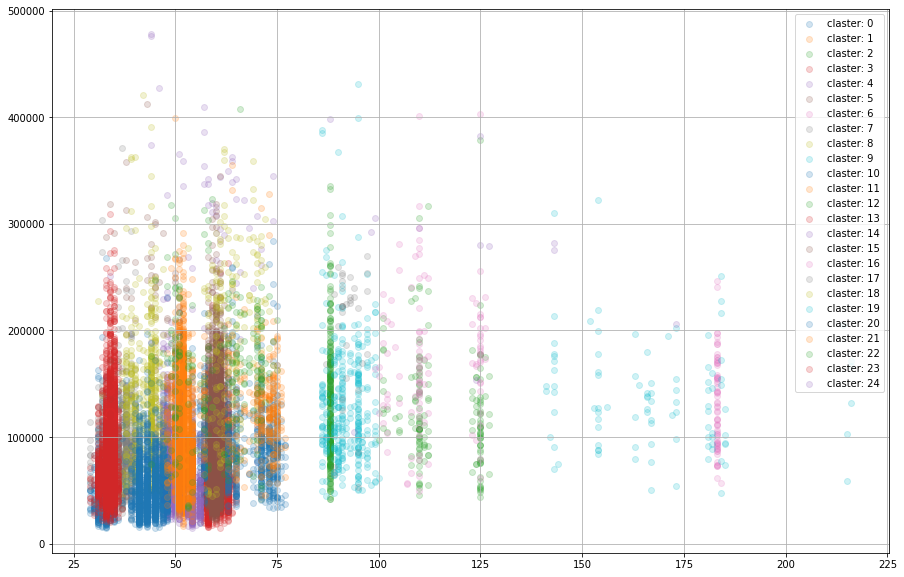

In [92]:
plt.figure(figsize=(15, 10))
plt.grid()
for i in np.unique(valid.pred_labels.unique()):
    plt.scatter(valid.area[i == valid.pred_labels].values, valid.price_m2_without_time[i==valid.pred_labels].values,
                cmap=colors_list[i], alpha=0.2, label ='claster: ' + str(i))
plt.legend()
plt.show()

In [93]:
df['labels'] = model.predict(df[features])
df_test['labels'] = model.predict(df_test[features])

In [94]:
df_train = df[df['mohth_from_begin'].values < 20]
df_valid = df[df['mohth_from_begin'].values > 20]


labels = ['labels'] 

initial_features = ['street_id', 'build_tech', 'floor', 'area', 'rooms', 'balcon', 'metro_dist', 'kw1', 'kw2']


cat_features_ = ['street_id']

target = ['price_without_time']

cat_features = cat_features_ + labels

features = initial_features + labels


train_pool = Pool(data = df_train[features], label = df_train[target], cat_features=cat_features
                 , weight=df_train.weights
                  )
valid_pool = Pool(data =df_valid[features], label = df_valid[target], cat_features=cat_features)

In [81]:
model = CatBoostRegressor(random_state=42, n_estimators = 15000, loss_function='MAE', eval_metric = 'MAE',
                          bagging_temperature =  0.43, depth=6, l2_leaf_reg = 199, learning_rate = 0.056, 
#                          task_type = 'GPU'
                         ) 
model.fit(train_pool, eval_set=valid_pool)                      
                
pred_train = model.predict(df_train[features])
pred_valid = model.predict(df_valid[features])
# pred_test = model.predict(df_test[features])

0:	learn: 2952525.7401266	test: 2193920.3267833	best: 2193920.3267833 (0)	total: 48.2ms	remaining: 12m 2s
1:	learn: 2832976.0694553	test: 2098999.8775199	best: 2098999.8775199 (1)	total: 85ms	remaining: 10m 37s
2:	learn: 2720231.1695407	test: 2009373.0463981	best: 2009373.0463981 (2)	total: 130ms	remaining: 10m 50s
3:	learn: 2615198.2259961	test: 1924692.2211167	best: 1924692.2211167 (3)	total: 172ms	remaining: 10m 43s
4:	learn: 2515925.6838908	test: 1848048.8578365	best: 1848048.8578365 (4)	total: 224ms	remaining: 11m 11s
5:	learn: 2423771.7510216	test: 1776551.3701104	best: 1776551.3701104 (5)	total: 277ms	remaining: 11m 31s
6:	learn: 2336216.1119362	test: 1706683.4311282	best: 1706683.4311282 (6)	total: 311ms	remaining: 11m 6s
7:	learn: 2256846.5702883	test: 1646198.7618443	best: 1646198.7618443 (7)	total: 356ms	remaining: 11m 7s
8:	learn: 2180234.1181489	test: 1588076.7890272	best: 1588076.7890272 (8)	total: 395ms	remaining: 10m 58s
9:	learn: 2113183.0735855	test: 1536022.3410682	b

KeyboardInterrupt: ignored

In [48]:
dict(zip(model.feature_names_, model.feature_importances_))

{'area': 47.047530494630536,
 'balcon': 0.3303255505978981,
 'build_tech': 8.152755303471087,
 'floor': 2.9827651619440507,
 'kw1': 0.2314165129991112,
 'kw2': 0.33272983080085866,
 'metro_dist': 3.1879416928174784,
 'n_photos': 1.6209317747555465,
 'rooms': 4.582907828883893,
 'street_id': 31.530695849099715}

In [49]:
from sklearn.metrics import mean_absolute_error
print("mae for model price without time")

print("train: ",mean_absolute_error(pred_train, df_train[target]))
print("valid: ", mean_absolute_error(pred_valid, df_valid[target]))

mae for model price without time
train:  333135.9339792463
valid:  373758.1476794886


In [52]:
df.groupby('n_photos').mean()


,street_id,build_tech,floor,area,rooms,balcon,metro_dist,kw1,kw2,kw3,kw4,kw5,kw6,kw7,kw10,kw11,kw12,kw13,price,year,mohth_from_begin,price_m2,weights_unique,weights_miss,weights,normal_price_month,normal_price_street,weight_price,pred_mean,model_time_coef,model_price_without_time,time_coef,price_without_time,normal_price_month_m2,normal_price_street_m2,weight_price_m2,model_pred_mean_m2,model_coef_price_m2,model_time_coef_m2,model_price_m2_without_time,time_coef_m2,price_m2_without_time,labels
n_photos,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,337.586278,0.507204,5.368439,50.438765,1.993997,0.384848,21.818182,0.049514,0.637221,0.008748,0.006404,0.003716,0.001086,0.000515,0.001830,0.000172,0.001658,0.000057,4.851995e+06,0.333219,10.474099,91623.516082,0.474461,0.925918,0.439407,-0.161472,-0.112280,2.562349e+06,5.682857e+06,1.151526,4.214750e+06,1.138109,4.265470e+06,-0.123177,-0.033048,44899.612828,104852.499800,0.874305,1.155232,79354.677936,1.137913,80564.023984,16.458605
1,336.908818,0.518129,5.363199,50.480683,1.990723,0.396629,21.891227,0.051700,0.630070,0.008089,0.006109,0.004412,0.001188,0.001188,0.001923,0.000396,0.001640,0.000113,4.832371e+06,0.325414,10.443181,91307.018740,0.474732,0.926283,0.439501,-0.158420,-0.098893,2.526861e+06,5.680650e+06,1.151079,4.203890e+06,1.137457,4.255793e+06,-0.122888,-0.019027,44483.432050,104810.909791,0.872168,1.154773,79160.760127,1.137328,80384.884764,16.481419
2,333.474730,0.519524,5.328447,50.618375,2.008384,0.392413,21.861808,0.050950,0.636550,0.007974,0.006332,0.003752,0.001759,0.000938,0.001290,0.000176,0.001935,0.000293,4.850147e+06,0.332024,10.445767,91819.139314,0.473320,0.925140,0.437809,-0.143168,-0.092154,2.535129e+06,5.680834e+06,1.151116,4.214398e+06,1.137662,4.265261e+06,-0.112037,-0.023517,44705.675234,104814.387979,0.876607,1.154812,79563.678530,1.137417,80785.847450,16.864916
3,336.683955,0.526063,5.318741,52.177677,2.110366,0.397226,21.864852,0.056531,0.626701,0.007099,0.005916,0.004338,0.001841,0.001183,0.002038,0.000263,0.001512,0.000263,5.152772e+06,0.329718,10.454085,95549.066627,0.477564,0.925904,0.442205,-0.028324,-0.004859,2.734195e+06,5.681428e+06,1.151237,4.477496e+06,1.137682,4.531574e+06,-0.034999,-0.002915,47467.986423,104825.577590,0.912032,1.154935,82778.948648,1.137557,84041.884815,17.404785
4,337.766286,0.525061,5.283592,53.420735,2.193143,0.398204,21.775510,0.058612,0.626939,0.007673,0.006857,0.004653,0.001878,0.001551,0.002122,0.000571,0.001878,0.000163,5.557512e+06,0.330531,10.479020,100672.595789,0.490370,0.926433,0.454198,0.092135,0.064781,3.031210e+06,5.683208e+06,1.151597,4.831185e+06,1.138073,4.890077e+06,0.072738,0.022215,51341.634460,104859.119218,0.960743,1.155305,87200.092113,1.137968,88533.350947,17.510694
5,331.317428,0.548307,5.337438,55.703765,2.335070,0.418423,21.915700,0.070921,0.629766,0.007933,0.006867,0.004618,0.001184,0.001184,0.002486,0.000592,0.001302,0.000474,6.192284e+06,0.341582,10.589155,107919.717637,0.509774,0.925991,0.471875,0.283051,0.185593,3.505593e+06,5.691071e+06,1.153191,5.372997e+06,1.140052,5.435372e+06,0.221292,0.046313,57374.240939,105007.267137,1.028149,1.156937,93318.032742,1.139986,94696.912983,17.344897
6,332.032956,0.560865,5.333059,58.765396,2.509990,0.431514,21.864058,0.071679,0.614624,0.008857,0.007415,0.004737,0.001442,0.001648,0.003502,0.000206,0.002060,0.000206,7.046162e+06,0.325438,10.286509,116127.233588,0.532980,0.929611,0.494928,0.481710,0.299515,4.225891e+06,5.669464e+06,1.148812,6.137236e+06,1.135532,6.212218e+06,0.379246,0.062758,64911.173551,104600.160645,1.111207,1.152451,100856.690518,1.135454,102377.387661,17.289598
7,339.890476,0.576667,5.246190,62.630000,2.657619,0.442857,21.895238,0.089048,0.603810,0.006190,0.007143,0.005714,0.002857,0.000476,0.005238,0.000476,0.001429,0.000476,8.517920e+06,0.340000,10.540476,130831.159113,0.583137,0.926324,0.540525,0.781731,0.441831,5.542170e+06,5.687596e+06,1.152486,7.413870e+06,1.139204,7.502046e+06,0.659595,0.122546,79203.268211,104941.786950,1.

метки не дали прироста, к сожалению

In [58]:
print("mae for result_price")
print("train: ", mean_absolute_error(pred_train * df_train.model_time_coef, df_train.price))
print("valid: ", mean_absolute_error(pred_valid * df_valid.model_time_coef, df_valid.price))

mae for result_price
train:  370003.17456437385
valid:  490988.22176898486


In [46]:
# sub = pd.read_csv('SampleSubmission.csv')
# sub.price = df_test.result_price

Подбираю гиперпараметры модели

In [ ]:
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
space = {
        'n_estimators': hp.quniform('n_estimators', 2000, 15000, 1),
        'depth': hp.quniform("depth", 3, 8, 1),
        'learning_rate': hp.loguniform('learning_rate', -3.0, -2),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.005, 200),
        'rsm': hp.uniform('rsm', 0.3, 1),
        'bagging_temperature': hp.uniform('bagging_temperature', 0.2, 1), 
       }
cur_loss = np.inf

In [ ]:
def objective(params):
    model = catboost.CatBoostRegressor(
                                       iterations= params['n_estimators'], 
                                       learning_rate = params['learning_rate'],
                                       depth = int(params['depth']),
                                       l2_leaf_reg = params['l2_leaf_reg'],
                                       rsm = params['rsm'],
                                       bagging_temperature = params['bagging_temperature'],
                                       loss_function = 'MAE',
                                       use_best_model = True,
                                    #    task_type = 'GPU',
                                       eval_metric = 'MAE'
                                       )
    model.fit(train_pool, eval_set = valid_pool, verbose = False)
    y_pred = model.predict(valid_pool) 
    loss = mean_absolute_error(valid_pool.get_label(), y_pred)
    print(loss)


    return {'loss':loss, 'status': STATUS_OK }



best = hyperopt.fmin(fn = objective, 
                     space = space,
                     algo = tpe.suggest,
                     max_evals = 100,
                     verbose = True,
                     )


In [ ]:
print(best)

{'bagging_temperature': 0.4284125413656453, 'depth': 6.0, 'l2_leaf_reg': 198.82058063891878, 'learning_rate': 0.05555877573482939, 'n_estimators': 14393.0, 'rsm': 0.996676586540747}